In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("../Donnees/cleaned_data.csv")


# Visualisation

In [2]:
number_columns = ["rating", "retirement", "time", "price", "review_count", "rating_value", "twenty_four_hours", "all_time"]
dfn = df[number_columns]

In [3]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest()
outliers = forest.fit_predict(dfn)



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


dfn = dfn.drop(index=np.where(outliers==-1)[0])
scaler = StandardScaler()  # Standardize numerical variables
dfn = pd.DataFrame(scaler.fit_transform(dfn), columns=number_columns)


In [ ]:
sns.pairplot(dfn)
plt.savefig("pairplot.png")

<Axes: >

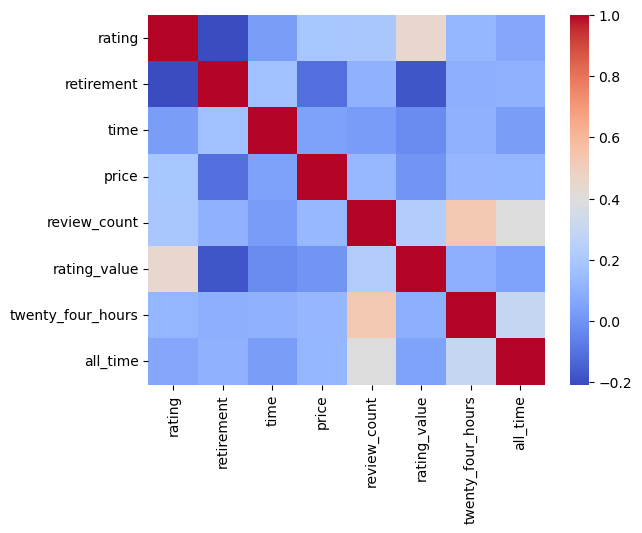

In [5]:
sns.heatmap(dfn.corr(),cmap="coolwarm")

Text(0.5, 0, 'Price')

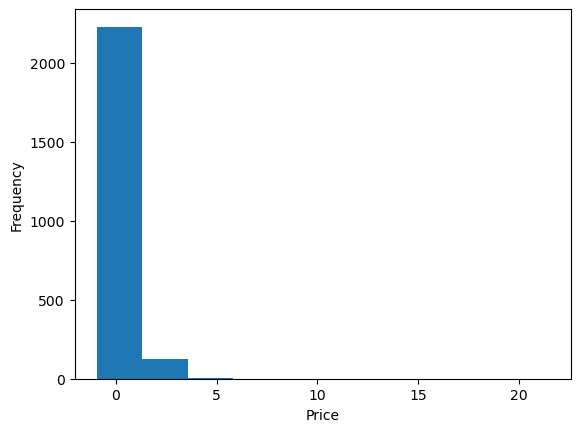

In [6]:
dfn["price"].plot.hist()
plt.xlabel("Price")

Text(0.5, 0, 'Rating')

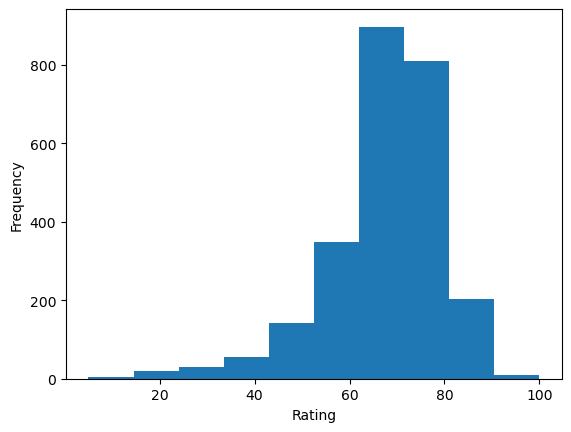

In [7]:
df['rating'].plot.hist()
plt.xlabel("Rating")

<Axes: >

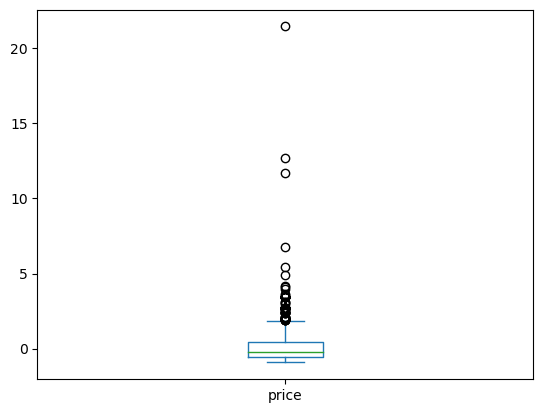

In [8]:
dfn["price"].plot.box()

In [9]:
df.describe()

,hltb_id,rating,retirement,date,time,price,pourcentage_pos,review_count,rating_value,twenty_four_hours,all_time,steam_id
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2.519000e+03,2519.000000,2519.000000,2.519000e+03,2.519000e+03
mean,31252.208416,67.546645,7.964629,2013.496626,34.175824,14.332189,82.342993,1.160413e+04,8.357285,920.874553,6.176490e+03,4.510454e+05
std,19325.401165,12.104395,5.992263,5.464294,282.550657,49.237890,13.019623,6.203766e+04,1.261397,14871.881692,3.475548e+04,3.160946e+05
min,38.000000,5.000000,0.500000,1987.000000,1.000000,0.000000,14.000000,1.100000e+01,2.000000,0.000000,0.000000e+00,5.000000e+01
25%,13307.500000,62.000000,3.800000,2012.000000,5.000000,4.990000,76.000000,3.875000e+02,7.000000,5.000000,1.080000e+02,2.558550e+05
50%,30088.000000,70.000000,6.400000,2015.000000,10.250000,9.990000,85.000000,1.534000e+03,9.000000,15.000000,4.840000e+02,3.930800e+05
75%,49988.000000,75.000000,10.000000,2017.000000,22.825000,19.500000,92.000000,5.314000e+03,9.000000,71.000000,2.174500e+03,6.100100e+05
max,63616.000000,100.000000,42.700000,2023.000000,9949.500000,2357.360000,100.000000,2.180390e+06,10.000000,712630.000000,1.291328e+06,2.450820e+06


# Traitement des colonnes

In [10]:
import ast

def dummies_list(df):
    df2 = pd.get_dummies(pd.DataFrame(df.values.tolist()), prefix_sep='', prefix='')
    merged_columns = {}
    for col_name, col_data in df2.items():
        if col_name.strip() not in merged_columns:
            merged_columns[col_name.strip()] = col_data
        else:
            merged_columns[col_name.strip()] += col_data
    merged_platform = pd.DataFrame(merged_columns)
    return merged_platform

def get_dummies_genres(X):
    X = X.dropna(axis="rows")
    X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)

    X_genre = dummies_list(X.genres)

    return X_genre


In [11]:
def reduce_genre_columns(df,nb_tags=150):

    X_genre = get_dummies_genres(df)
    X_genre = X_genre.drop(index=np.where(outliers==-1)[0])
    colsum = list(zip(X_genre.columns, X_genre.sum()))
    to_drop = sorted(colsum, key=lambda x:x[1], reverse=True)[nb_tags:]
    to_drop = [e[0] for e in to_drop]
    X_genre = X_genre.drop(to_drop, axis=1)
    return X_genre

X_genre = reduce_genre_columns(df,799)


C:\Users\rapha\AppData\Local\Temp\ipykernel_21396\704342877.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)


<Axes: >

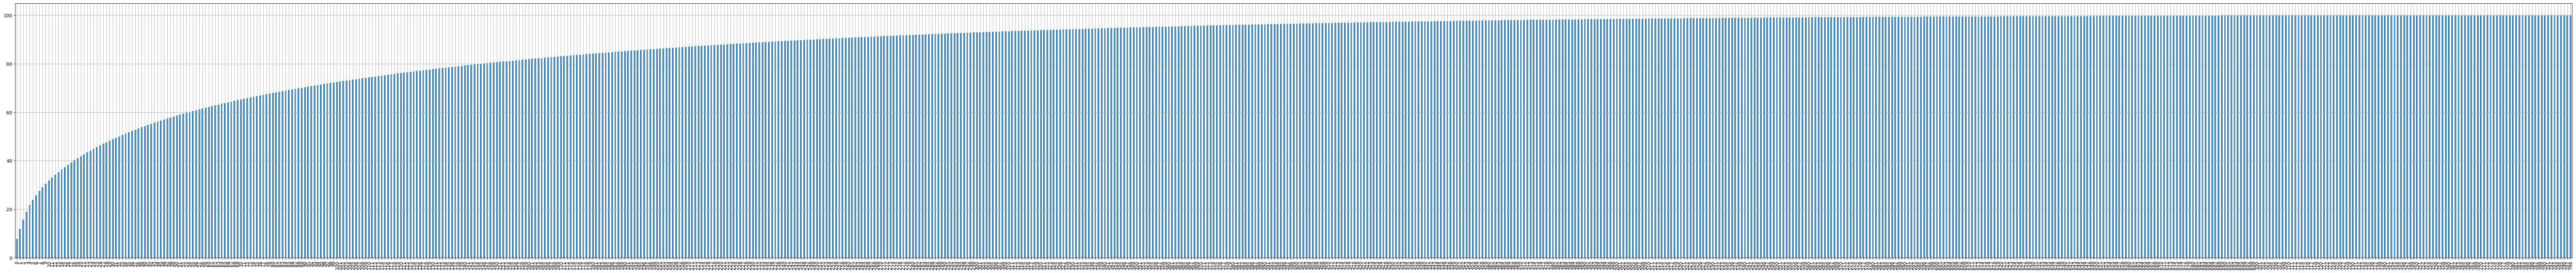

In [12]:
#X_genre = X_genre.drop(index=np.where(outliers==-1)[0])


# reduction de dimension

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_genre)

summary = pd.DataFrame({"variances":pca.explained_variance_,"ratio":pca.explained_variance_ratio_,"cumulative ratio":np.cumsum(pca.explained_variance_ratio_)})
(100*summary['cumulative ratio']).plot.bar(figsize=(100,10),grid=True)


In [22]:
def get_X_with_genres_after_pca(X_genre,nb_components):
    pca = PCA()
    pca.fit(X_genre)
    pca_data = pca.transform(X_genre)
    pca_data = pd.DataFrame(pca_data).drop(list(range(nb_components,799)),axis='columns')
    df_with_genres_simplifie = pd.merge(df,pca_data,how = "left",left_index=True,right_index=True)
    df_with_genres_simplifie = df_with_genres_simplifie.drop("genres",axis=1)
    df_with_genres_simplifie.columns = df_with_genres_simplifie.columns.astype(str)
    return df_with_genres_simplifie 

2355    799


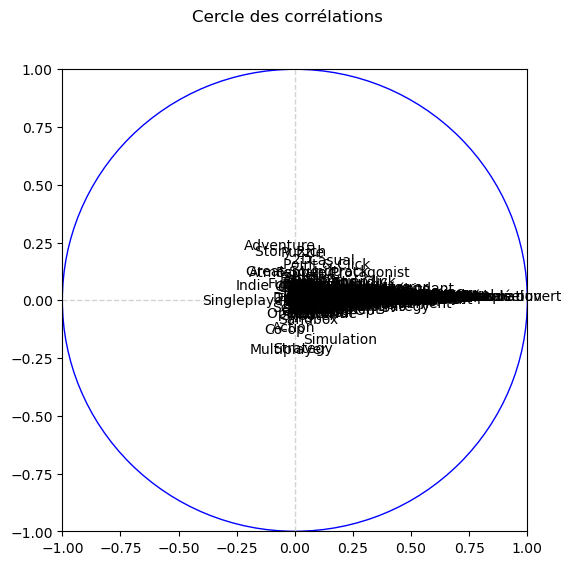

In [14]:

# Cercle de correlation 
n = X_genre.shape[0] # nb of individuals
p = X_genre.shape[1] # nb of variables
print(n, '  ', p)
eigval = (n-1) / n * pca.explained_variance_ # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p)) # empty matrix for coordinates
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': X_genre.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

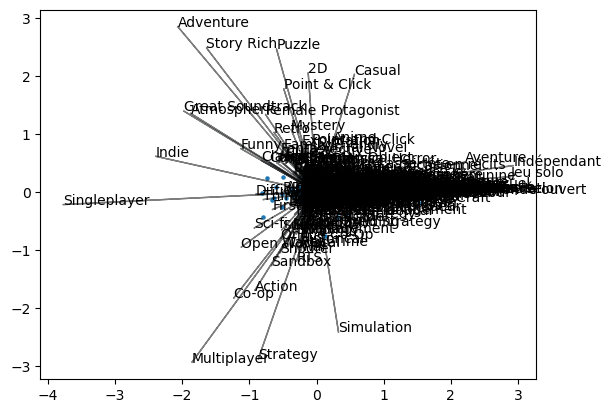

In [15]:
pca_data = pca.transform(X_genre)

plt.scatter(pca_data[0],pca_data[1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,X_genre.columns[i])

# Analyses

### PCA sur tout

<Axes: >

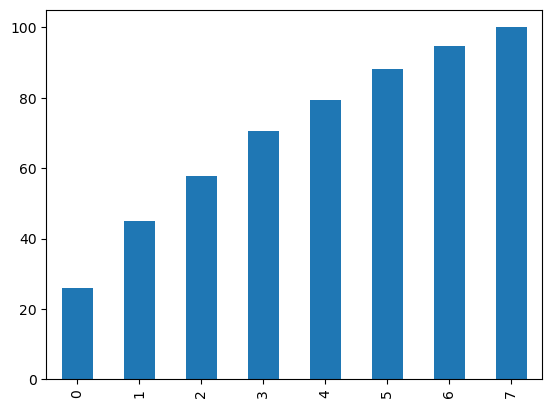

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfn)
data = scaler.transform(dfn) # normalisation
dataframe = pd.DataFrame(data)
pca = PCA()
pca.fit(dataframe)

summary = pd.DataFrame({"variances":pca.explained_variance_,"ratio":pca.explained_variance_ratio_,"cumulative ratio":np.cumsum(pca.explained_variance_ratio_)})
(100*summary['cumulative ratio']).plot.bar()

2360    8


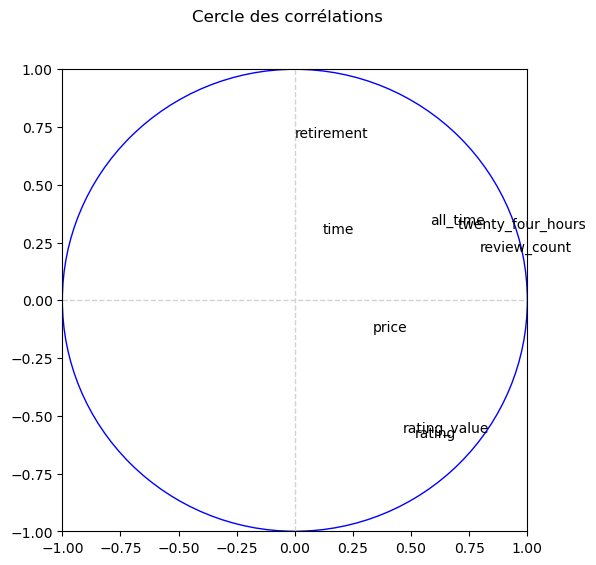

In [17]:
pca_data = pca.transform(dataframe)
pca_data = pd.DataFrame(pca_data).drop([5,6,7],axis='columns') # on ne garde que les 3 premières dimensions (80% de l'information)

# Cercle de correlation 
n = data.shape[0] # nb of individuals
p = data.shape[1] # nb of variables
print(n, '  ', p)
eigval = (n-1) / n * pca.explained_variance_ # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p)) # empty matrix for coordinates
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': dfn.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

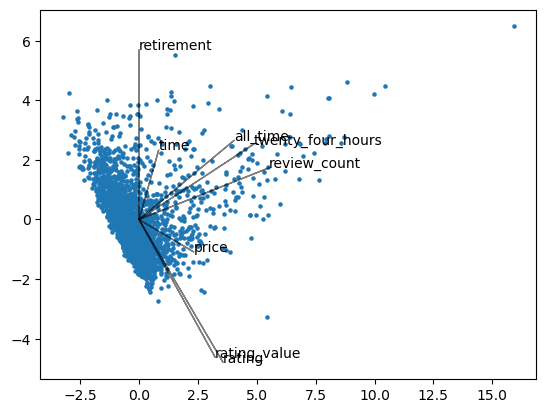

In [18]:
plt.scatter(pca_data[0],pca_data[1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,dfn.columns[i])

c:\Users\rapha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rapha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rapha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


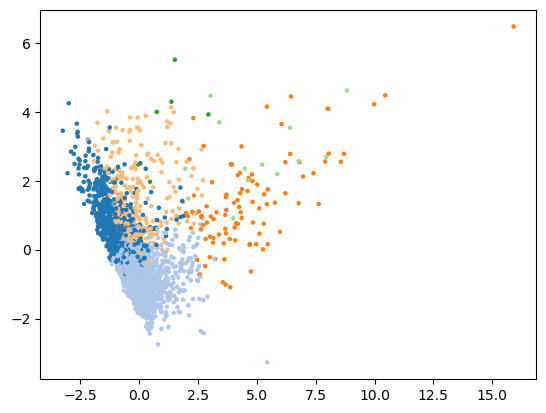

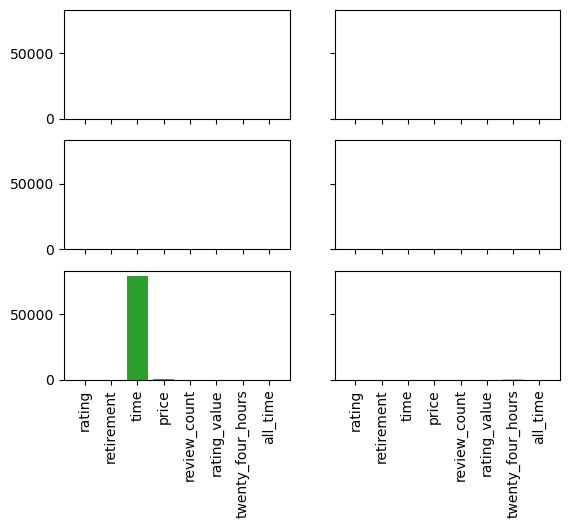

In [19]:
from sklearn.cluster import KMeans
tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=6)
pred = km.fit_predict(data)
plt.scatter(pca_data[0],pca_data[1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)


real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))
fig, axs = plt.subplots(km.n_clusters//2, 2, sharey=True,sharex=True)
for i,k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)),k,color=tab20.colors[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(dfn.columns,rotation="vertical")

### Prédiction du rating en fonction du genre, de la platforme, de la date de sortie et du prix.

In [20]:

def X_with_dummies(X,column):
    X = X.dropna(axis="rows")
    X[column] = X[column].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes

    X_column = dummies_list(X[column])

    X = X.drop(column,axis=1)

    X = pd.merge(X,X_column,how = "left",left_index=True,right_index=True)

    return X

def X_with_dummies_genre_platform(X,nb_genre=10):
    X = X.dropna(axis="rows")
    X['platform'] = X['platform'].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
    X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)

    X_platform = dummies_list(X.platform)

    #X_genre = dummies_list(X.genre)
    X_genre = get_dummies_genres(X)
    X_genre = reduce_genre_columns(X,nb_genre)

    #X = X.drop("platform",axis=1)
    X = X.drop(columns=["platform","genres"])

    X = pd.merge(X,X_platform,how = "left",left_index=True,right_index=True)
    X = pd.merge(X,X_genre,how = "left",left_index=True,right_index=True)

    return X


Test avec les colonnes trouvées par la PCA pour le genre :

C:\Users\rapha\AppData\Local\Temp\ipykernel_21396\894188407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
C:\Users\rapha\AppData\Local\Temp\ipykernel_21396\894188407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
C:\Users\rapha\AppData\Loc

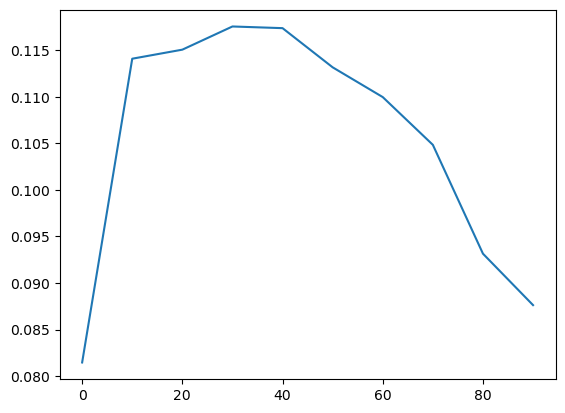

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

L = []
for n in range(0,100,10):
    df_with_genres_simplifie = get_X_with_genres_after_pca(X_genre,n)

    X = df_with_genres_simplifie.drop(columns=['hltb_id','pourcentage_pos','review_count','retirement', 'rating_value', 'players_by_time','title','description', 'steam_id'])
    
    X = X_with_dummies(X,"platform")
    y = X['rating']
    X = X.drop("rating",axis=1)
    #X = X.drop(index=np.where(outliers==-1)[0])
    #y = y.drop(index=np.where(outliers==-1)[0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = list(y_train)
    y_test = list(y_test)


    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    L.append(r2)

plt.plot(range(0,100,10),L)


Test avec les colonnes de base :

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

L = []
for n in range(0,100,10):

    X = df[['platform', 'genres', 'date', 'price','time']]
    y = df['rating']    
    X = X_with_dummies_genre_platform(X)

    #X = X.drop(index=np.where(outliers==-1)[0])
    #y = y.drop(index=np.where(outliers==-1)[0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = list(y_train)
    y_test = list(y_test)


    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    L.append(r2)

plt.plot(range(0,100,10),L)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Prédiction du retirement en fonction du rating, de la plateforme, du genre, de la date et du prix

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Preprocessing
X = df[['rating',"pourcentage_pos", 'platform', 'genres', 'date', 'price','time',"twenty_four_hours","all_time"]]
y = df['retirement']

X = X_with_dummies_genre_platform(X)

X = X.drop(index=np.where(outliers==-1)[0])
y = y.drop(index=np.where(outliers==-1)[0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict retirement on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Squared Error: 17.48181555084746
R-squared: 0.3470818120839627


## Clusters

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df[['platform', 'genres', 'rating']]
X = X_with_dummies_genre_platform(X)
X = X.dropna()
#scaler = StandardScaler()  # Standardize numerical variables
#X_scaled = scaler.fit_transform(X_encoded)



c:\Users\rapha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


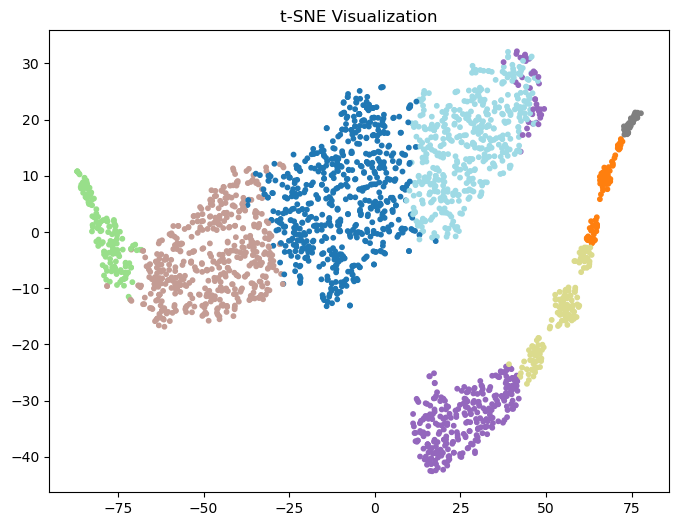

In [39]:
# t-SNE
from sklearn.manifold import TSNE

tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=5)
km.n_clusters = 8
pred = km.fit_predict(X)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=pred, cmap='tab20', s=10)
plt.title('t-SNE Visualization')
plt.show()

# Explicabilité